<a href="https://colab.research.google.com/github/maidacundo/DeepLearningREPO/blob/main/Esame-Soluzione-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, MaxPooling2D, Add, Dropout, ConvLSTM2D, GaussianNoise, BatchNormalization , Activation, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [ ]:
(x_train_blured, x_train), (x_test_blured, x_test) = getDataset()
print(f"Train size: {x_train_blured.shape}. Test size: {x_test_blured.shape}")

Train size: (50000, 32, 32, 3). Test size: (10000, 32, 32, 3)


In [ ]:
def res_block(x, filter, kernel_size):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def dense_block(x, filters, kernel_size, layers):
  layers_connections = []
  layers_connections.append(x)
  for i in range(layers):
    cat = sum(layers_connections)
    x = res_block(cat, filters,kernel_size)
    layers_connections.append(x)
  x = tf.keras.layers.Add()([x, cat])
  return x

In [ ]:
# modello

# input
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# upsampling

x = Conv2D(64, (2, 2), strides = 1, padding = 'same') (inputs)
x = res_block(x, 64,(2, 2))
x = res_block(x, 64,(2, 2))
x = res_block(x, 64,(2, 2))

conv_1 = MaxPooling2D((2, 2), strides = 2, padding='same') (x)

x = Conv2D(32, (2, 2), strides = 1, padding = 'same') (conv_1)
x = res_block(x, 32,(2, 2))
x = res_block(x, 32,(2, 2))
x = res_block(x, 32,(2, 2))

conv_2 = x


x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (conv_2)
x = res_block(x, 16,(2, 2))
x = res_block(x, 16,(2, 2))
conv_3 = res_block(x, 16,(2, 2))

# hidden layer
h_1 = Conv2D(16, (3, 3), strides = 1, padding = 'same') (conv_3)
h_2 = Conv2D(16, (3, 3), strides = 1, padding = 'same') (conv_3)
h_3 = Conv2D(16, (3, 3), strides = 1, padding = 'same') (conv_3)

x = h_1 + h_2 + h_3
# deconvolution

cat_0 = x + conv_3

x = res_block(cat_0, 16,(2, 2))
x = res_block(x, 16,(2, 2))
x = res_block(x, 16,(2, 2))
x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)

cat_1 = x + conv_2

x = res_block(cat_1, 32,(2, 2))
x = res_block(x, 32,(2, 2))
x = res_block(x, 32,(2, 2))
x = Conv2DTranspose(64, (3, 3), strides = 1, padding = 'same') (x)

# transpose here
cat_2 = UpSampling2D((2,2)) (x + conv_1)

x = res_block(cat_2, 64,(2, 2))
x = res_block(x, 64,(2, 2))
x = res_block(x, 64,(2, 2))

# max pooling

x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)

outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)

In [ ]:
model = Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1300 (Conv2D)           (None, 32, 32, 64)   832         ['input_45[0][0]']               
                                                                                                  
 conv2d_1301 (Conv2D)           (None, 32, 32, 64)   16448       ['conv2d_1300[0][0]']            
                                                                                                  
 activation_1121 (Activation)   (None, 32, 32, 64)   0           ['conv2d_1301[0][0]']            
                                                                                           

In [ ]:
model.compile(loss='mse', optimizer='adam',metrics=['acc'])

hist = model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs=20, 
          batch_size=200, 
          validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 30s 128ms/step - loss: 0.0180 - acc: 0.4896 - val_loss: 0.0068 - val_acc: 0.6502
Epoch 2/20
225/225 [==============================] - 28s 126ms/step - loss: 0.0058 - acc: 0.6749 - val_loss: 0.0051 - val_acc: 0.6926
Epoch 3/20
225/225 [==============================] - 28s 126ms/step - loss: 0.0051 - acc: 0.6892 - val_loss: 0.0058 - val_acc: 0.6869
Epoch 4/20
225/225 [==============================] - 28s 126ms/step - loss: 0.0046 - acc: 0.7161 - val_loss: 0.0041 - val_acc: 0.7951
Epoch 5/20
225/225 [==============================] - 28s 126ms/step - loss: 0.0037 - acc: 0.8099 - val_loss: 0.0034 - val_acc: 0.8169
Epoch 6/20
225/225 [==============================] - 28s 126ms/step - loss: 0.0034 - acc: 0.8211 - val_loss: 0.0032 - val_acc: 0.8292
Epoch 7/20
225/225 [==============================] - 28s 126ms/step - loss: 0.0032 - acc: 0.8284 - val_loss: 0.0031 - val_acc: 0.8295
Epoch 8/20
225/225 [==============================] - 2

In [ ]:
print(model.optimizer.get_config())

{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


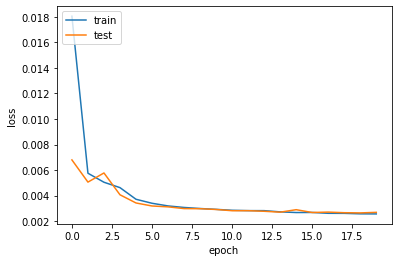

In [ ]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])

In [ ]:
from tensorflow.keras.losses import MeanSquaredError

y_true = x_test
y_pred = model.predict(x_test_blured)

mse = MeanSquaredError()
mse(y_true, y_pred).numpy()

#0.0023

#0.0041738243220982366
#0.004219622105503972
#0.00404854369862134
#0.003909846398674108
#0.00379532259022029
#0.003393252
#0.0026358136

0.0026967807

In [ ]:
#utility function to pick samples to be tested

def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp

num = 3
figsize = 15
org, temp = get_samples(x_test, num)
blur = x_test_blured[temp]
preds = model.predict(blur.reshape(-1, 32, 32, 3))
#plotting results
plt.figure(figsize = (figsize, figsize))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
plt.show()

In [ ]:
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Flatten
from keras.layers import BatchNormalization
from keras.models import Model


from keras.layers import Input, Activation, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Lambda
from keras.models import Model

ndf = 64
ngf = 64
n_blocks_gen = 9
output_nc = 3
input_shape_discriminator = (32, 32, output_nc)

inputs = Input(shape=(32, 32, 3))

x = Conv2D(filters=ngf, kernel_size=(2,2), padding='valid')(inputs)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
print(x)
# Increase filter number
n_downsampling = 2
for i in range(n_downsampling):
    mult = 2**i
    x = Conv2D(filters=ngf*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
    print(x)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)

# Apply 9 ResNet blocks
mult = 2**n_downsampling
for i in range(n_blocks_gen):
    x = res_block(x, ngf*mult, (2, 2))

# Decrease filter number to 3 (RGB)
for i in range(n_downsampling):
    mult = 2**(n_downsampling - i)
    x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(2, 2), strides=2-i, padding='same')(x)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same')(x)

x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
x = Conv2D(filters=64, kernel_size=(2,2), padding='same')(x)
x = Conv2D(filters=output_nc, kernel_size=(1,1), padding='same')(x)

x = Activation('tanh')(x)

# Add direct connection from input to output and recenter to [-1, 1]
outputs = Add()([x, inputs])
outputs = Lambda(lambda z: z/2)(x)
print(outputs)
x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
#decode
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same') (x)
outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)
model = Model(inputs=inputs, outputs=outputs, name='Generator')
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), name='lambda_5/truediv:0', description="created by layer 'lambda_5'")
Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_2008 (Conv2D)           (None, 31, 31, 64)   832         ['input_73[0][0]']               
                                                                                                  
 activation_1805 (Activation)   (None, 31, 31, 64)   0           ['conv2d_2008[0][0]']            
                                                                                                  
 conv2d_2009 (Conv2D)          